In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend as K 
import gym
import numpy as np
import random as rand

DQN
=======

In [3]:
class Agent(object):
    def __init__(self):
        # 프로그램 동작 설정
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0] # cartpole이 가진 state 개수
        self.action_size = self.env.action_space.n # cartpole의 agent가 선택할 수 있는 action의 개수

        # model의 설정
        self.node_num = 12 # nn layer에 들어있는 node의 개수
        self.learning_rate = 0.001
        self.epochs_cnt = 5
        self.model = self.build_model()
        
        # 학습 설정
        self.discount_rate = 0.97
        self.penalty = -100 # 막대가 cartpole에서 떨어져 종료되었을 때 받을 음의 보상의 크기
        
        # 반복 설정 영역 
        self.episode_num = 500 # 몇 번의 episode를 반복하여 data를 수집할 것인가

        # data 수집 환경
        self.replay_memory_limit = 2048
        self.replay_size = 32 # mini batch통해 학습할 데이터의 양을 지정
        self.replay_memory = [] # 수집한 cartpole의 실행 정보가 저장

        # 탐험 환경 설정
        self.epsilon = 0.99
        self.epsilon_decay = 0.2
        self.epsilon_min = 0.05

        # training monitoring
        self.moving_avg_size = 20 # moving average size3
        self.reward_list = []
        self.count_list = [] # 각 episode에서 cartpole이 실행된 횟수
        self.moving_avg_list = []

    def build_model(self): # neural net build
        input_states = Input(shape = (1,self.state_size), name = "input_states") # model : state -> q value for each action
        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x) # hidden layer의 node 개수
        out_actions = Dense(self.action_size, activation = "linear", name = "output")(x) # output layer = q value per actions
        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_actions])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate), loss = "mean_squared_error")
        model.summary()
        return model
    
    def train(self): # train the model
        for episode in range(self.episode_num): # step : cartpole이 한 번 실행되는 것 // episode : cartpole이 처음 실행되어 종료될 때까지의 전 과정
            state,_ = self.env.reset() # cartpole 실행 환경의 초기화
            Q, count, reward_tot = self.take_action_and_append_memory(episode, state) # 경험을 기록

            if count < 500:
                reward_tot = reward_tot - self.penalty
            
            # 하나의 episode 종료 -> 수집된 보상과 실행 횟수 저장
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            # replay memory에 저장된 데이터를 replay_size만큼 가져와서 학습
            self.train_mini_batch(Q)

            # training log
            if (episode%10 == 0 ):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1],np.mean(self.reward_list)))
        self.save_model()

    def take_action_and_append_memory(self, episode, state):
        reward_tot = 0
        count = 0
        done = False

        epsilon = self.get_epsilon(episode) # epsilon 계산 w/ decay -> determin whether exploration or exploitation
        while not done: # 반복 설정
            count+=1
            state_t = np.reshape(state, [1,1,self.state_size])
            Q = self.model.predict(state_t,verbose = 0) # Q값을 예측
            action = self.greed_search(epsilon, episode, Q) # action을 선택
            state_next, reward, done, _, _ = self.env.step(action) # 행동을 실행 -> 환경이 다음 state와 reward를 return

            if done: # 막대가 바닥에 떨어진 경우
                reward = self.penalty
            self.replay_memory.append([state_t, action, reward, state_next, done]) # 경험을 replay_memory에 저장
            if len(self.replay_memory)>self.replay_memory_limit: # replay_memory가 너무 커지면 오래된 정보부터 삭제
                del self.replay_memory[0]
            reward_tot += reward
            state = state_next
        return Q, count, reward_tot
    
    def train_mini_batch(self, Q): # train via replay memory
        array_state = []
        array_Q = []
        this_replay_size = self.replay_size # 학습에 사용할 데이터의 크기
        if len(self.replay_memory) < self.replay_size: # 기존에 저장되어 있던 정보보다 작은 양의 정보가 replay_memory에 있는 경우 : exception handling
            this_replay_size = len(self.replay_memory)
        
        for sample in rand.sample(self.replay_memory, this_replay_size): # radom sampling
            state_t, action, reward, state_next, done = sample # training data 분리

            # Q값 계산
            if done : # 게임이 종료된 경우 -> 다음 상태가 없음
                Q[0, 0, action] = reward
            else: # 게임이 종료되지 않은 경우
                state_t = np.reshape(state_next, [1,1,self.state_size])
                Q_new = self.model.predict(state_t, verbose = 0)
                Q[0, 0, action] = reward + self.discount_rate*np.max(Q_new)

            # data shape 변경
            array_state.append(state_t.reshape(1,self.state_size))
            array_Q.append(Q.reshape(1,self.action_size))
        array_state_t = np.array(array_state)
        array_Q_t = np.array(array_Q)

        # model의 학습
        hist = self.model.fit(array_state_t, array_Q_t, epochs = self.epochs_cnt, verbose = 0)

    def get_epsilon(self, episode):
        result = self.epsilon * (1- episode/(self.episode_num*self.epsilon_decay))
        if result < self.epsilon_min:
            result = self.epsilon_min
        return result
    
    def greed_search(self, epsilon, episode, Q) : 
        if epsilon > np.random.rand(1):
            action = self.env.action_space.sample()
        else:
            action = np.argmax(Q)
        return action
    
    def moving_avg(self, data, size = 10):
        if len(data) > size:
            c = np.array(data[len(data) - size: len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/dqn")
        print("****** end learning")

In [48]:
if __name__ == "__main__" : 
    agent = Agent()
    agent.train()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 1, 4)]            0         
                                                                 
 dense_13 (Dense)            (None, 1, 12)             60        
                                                                 
 output (Dense)              (None, 1, 2)              26        
                                                                 
Total params: 86 (344.00 Byte)
Trainable params: 86 (344.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 22.0, rewards_avg : 21.0
episode : 10, moving_avg : 26.818181818181817, rewards_avg : 25.818181818181817
episode : 20, moving_avg : 24.35, rewards_avg : 23.238095238095237
episode : 30, moving_avg : 21.9, rewards_avg : 22.64516129032258
episode : 40, moving_avg : 22.2, rewards_avg : 22.24390243902439
episode : 50, moving_avg : 19.25, rewards_avg : 20.92156862745098
episode : 60, moving_avg : 18.6, rewards_avg : 20.721311475409838
episode : 70, moving_avg : 25.8, rewards_avg : 22.014084507042252
episode : 80, moving_avg : 38.0, rewards_avg : 24.74074074074074
episode : 90, moving_avg : 36.1, rewards_avg : 24.89010989010989
episode : 100, moving_avg : 18.6, rewards_avg : 23.326732673267326
episode : 110, moving_avg : 9.95, rewards_avg : 22.01801801801802
episode : 120, moving_avg : 12.05, rewards_avg : 21.297520661157026
episode : 130, moving_avg : 19.9, rewards_avg : 21.541984732824428
episode : 140, moving_avg : 23.95, rewards_avg : 21.53191489361702
episode :

INFO:tensorflow:Assets written to: ./model?dqn/assets


****** end learning


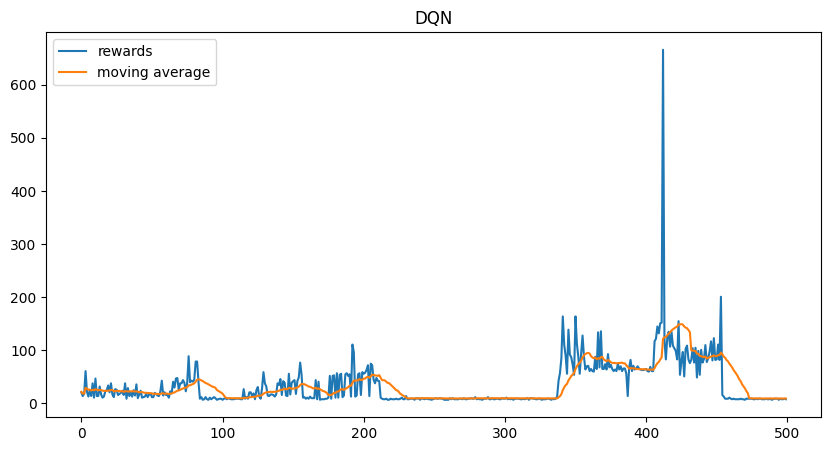

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("DQN")
plt.show()

REINFORCE
========

In [104]:
class Agent(object):
    def __init__(self):
        # 프로그램의 동작 설정
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1 # 보상값의 크기

        self.node_num = 12
        
        self.learning_rate = 0.0005
        self.epochs_cnt = 5
        self.model = self.build_model()

        self.discount_rate = 0.95
        self.penalty = -10

        self.episode_num = 500

        self.moving_avg_size = 20

        # data 수집 환경
        self. states, self.action_matrices, self.action_probs, self.rewards = [], [], [], []
        self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD = np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size)) # parameter의 개수를 맞춰주기 위함

        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

    class MyModel(tf.keras.Model):
        def train_step(self, data): # overriding for user defined cost function
            # 입력 변수 설정
            in_datas, out_actions = data
            states, action_matrix, rewards = in_datas[0], in_datas[1], in_datas[2]
            with tf.GradientTape() as tape: # for auto gradient 
                y_pred = self.call(states, training = True) # 행동 예측(좌/우). Note : self는 GradientTape Object
                action_probs = K.sum (action_matrix*y_pred, axis = -1) # 확률 계산 (SoftMax)
                loss = -K.log(action_probs) * rewards
            trainable_vars = self.trainable_variables # Model Class 내부에서 Weight & Bias를 저장

            gradients = tape.gradient(loss, trainable_vars) # gradient calc
            self.optimizer.apply_gradients(zip(gradients, trainable_vars)) # 최적화 알고리즘을 통해 입력된 변수에 대한 gradient 적용
            self.compiled_metrics.update_state(out_actions, y_pred)
            return {m.name: m.result() for m in self.metrics}

    def build_model(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1,self.action_size), name = "input_action_matrices")
        input_rewards = Input(shape = (1,self.value_size), name = "input_rewards")

        x = (input_states)
        x = Dense(self.node_num, activation = "tanh")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_rewards], outputs = out_actions)

        model.compile(optimizer = Adam(learning_rate = self.learning_rate))

        model.summary()
        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_steps = 500
            count, reward_tot = self.make_memory(episode, state) # data 수집
            self.train_mini_batch() # model training
            self.clear_memory() # data 삭제

            if count<500:
                reward_tot -= self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            if(episode % 10 == 0):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1],np.mean(self.reward_list)))
        self.save_model()

    def make_memory(self, episode, state) : 
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count +=1
            state_t = np.reshape(state, [1,1,self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1,1,self.action_size])

            action_prob = self.model.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD], verbose = 0) # action 예측
            # Note : action_matrix & reward -> only for training

            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0] # action 선택
            action_matrix = np.zeros(self.action_size) # action matrix : 0 or 1
            action_matrix[action] = 1 # 1 for stochatically chosen action

            state_next, reward, done,_, _ = self.env.step(action)

            if count<500 and done:
                reward = self.penalty

            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix, [1, self.action_size]))
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(reward)
            reward_tot += reward
            state = state_next
        return count, reward_tot
    
    def clear_memory(self):
        self.states, self.action_matrices, self.action_probs, self.rewards = [], [], [], []

    def make_discount_rewards(self, rewards):
        discounted_rewards = np.zeros(np.array(rewards).shape)
        running_add = 0
        for t in reversed(range(0,len(rewards))): # 마지막 index부터 반복
            running_add = running_add * self.discount_rate + rewards[t] # 할인된 반환값 계산
            discounted_rewards[t] = running_add
        return discounted_rewards
    
    def train_mini_batch(self):
        discount_rewards = np.array(self.make_discount_rewards(self.rewards)) # 반환값 계산
        discount_rewards_t = np.reshape(discount_rewards, [len(discount_rewards),1, 1])
        states_t = np.array(self.states)
        action_matrices_t = np.array(self.action_matrices)
        action_probs_t = np.array(self.action_probs)
        self.model.fit([states_t, action_matrices_t, discount_rewards_t], y = action_probs_t, epochs=self.epochs_cnt, verbose=0)
        
    def moving_avg(self,data, size = 10):
        if len(data)>size:
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/reinforce")
        print("****** end learning")    
    

In [105]:
if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "my_model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 1, 4)]               0         []                            
                                                                                                  
 dense_24 (Dense)            (None, 1, 12)                60        ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 1, 2)]               0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_rewards (InputLayer)  [(None, 1, 1)]               0         []                  

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 23.0, rewards_avg : 22.0
episode : 10, moving_avg : 14.818181818181818, rewards_avg : 13.818181818181818
episode : 20, moving_avg : 15.15, rewards_avg : 14.523809523809524
episode : 30, moving_avg : 14.3, rewards_avg : 13.483870967741936
episode : 40, moving_avg : 14.0, rewards_avg : 13.78048780487805
episode : 50, moving_avg : 16.5, rewards_avg : 14.27450980392157
episode : 60, moving_avg : 15.4, rewards_avg : 13.98360655737705
episode : 70, moving_avg : 15.3, rewards_avg : 14.28169014084507
episode : 80, moving_avg : 19.7, rewards_avg : 15.148148148148149
episode : 90, moving_avg : 23.3, rewards_avg : 16.043956043956044
episode : 100, moving_avg : 31.75, rewards_avg : 18.237623762376238
episode : 110, moving_avg : 39.85, rewards_avg : 20.153153153153152
episode : 120, moving_avg : 35.0, rewards_avg : 20.84297520661157
episode : 130, moving_avg : 37.55, rewards_avg : 22.65648854961832
episode : 140, moving_avg : 45.55, rewards_avg : 24.20567375886525
episode 

INFO:tensorflow:Assets written to: ./model/reinforce/assets


****** end learning


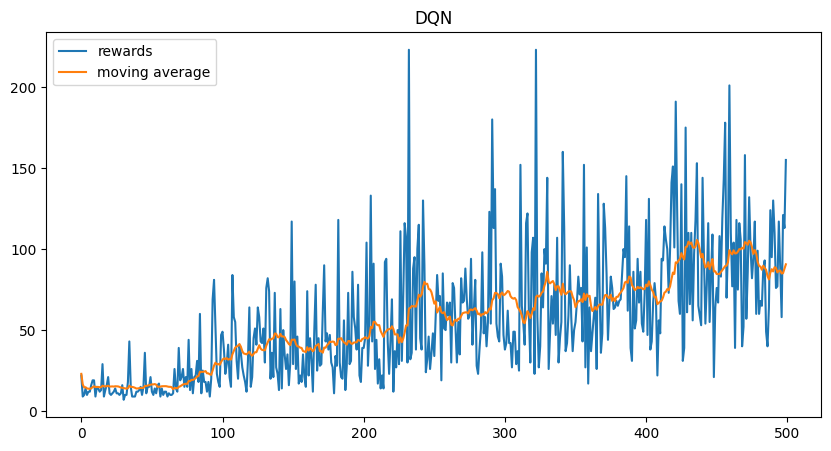

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("DQN")
plt.show()

ref : https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/12/REINFORCE-CartPole.html

In [ ]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

In [17]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps', index=0)

In [58]:
env = gym.make("CartPole-v1")
env.observation_space.seed(0)
env.action_space.seed(0)

print("observation space : ", env.observation_space)
print("action space : ", env.action_space)

observation space :  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space :  Discrete(2)


In [59]:
class Policy(nn.Module):
    def __init__(self,state_size = 4, action_size = 2, hidden_size = 32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state) :
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        
        return F.softmax(x, dim = 1)
    
    def act(self, state) : 
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [60]:
def reinforce(policy, optimizer, n_episodes = 1000, max_t = 1000, gamma = 1.0, print_every = 100):
    scores_deque = deque(maxlen = 100)
    scores = []
    for e in range(n_episodes):
        saved_log_probs = []
        rewards = []
        state,_ = env.reset()

        # collect trajectories
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done : 
                break

        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discount = [gamma ** i for i in range(len(rewards)+1)]
        R = sum([a*b for a, b in zip(discount, rewards)])

        # Calculate the loss
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)

        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e%print_every == 0:
            print("episode : {}\t Average Score : {:.2f}".format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores


In [63]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=2000)
torch.save(policy.state_dict(),"./model/reinforce_torch")

episode : 0	 Average Score : 16.00
episode : 100	 Average Score : 28.22
episode : 200	 Average Score : 47.33
episode : 300	 Average Score : 82.70
episode : 400	 Average Score : 72.36
episode : 500	 Average Score : 77.09
episode : 600	 Average Score : 70.83
episode : 700	 Average Score : 59.54
episode : 800	 Average Score : 63.33
episode : 900	 Average Score : 69.09
episode : 1000	 Average Score : 69.71
episode : 1100	 Average Score : 100.43
episode : 1200	 Average Score : 107.08
episode : 1300	 Average Score : 194.76
Environment solved in 1201 episodes!	Average Score: 198.87


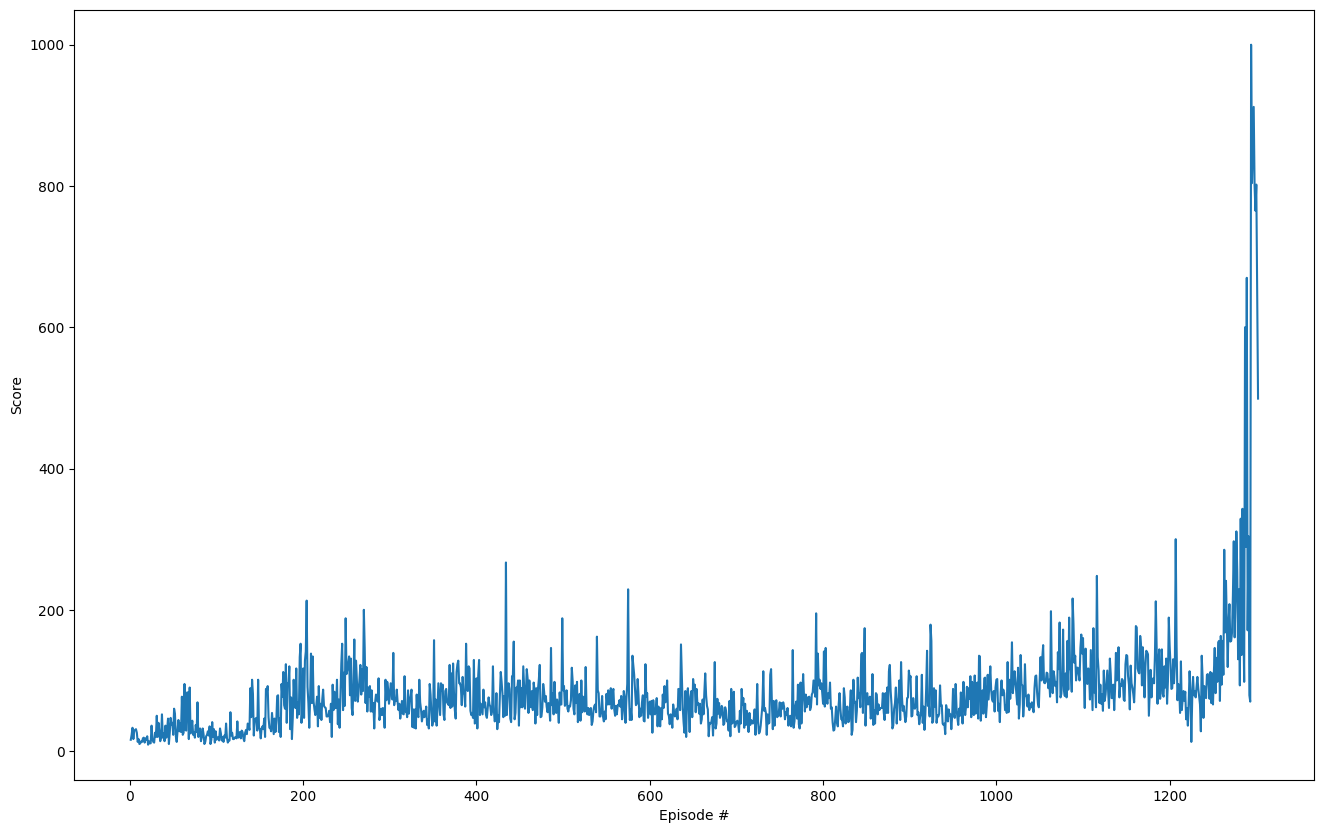

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Advantage Action Critic
=============

In [109]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam, SGD

In [ ]:
class Agent(object):
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.node_num = 12
        self.learning_rate = 0.002
        self.epoch_cnt = 1
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()

        self.discount_rate = 0.95
        self.penalty = -100

        self.episode_num = 500

        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADAVANTAGE = np.zeors((1, self.action_size)), np.zeros((1, self.value_size))

    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrices, advantages = in_datas[0], in_datas[1], in_datas[2]

            with tf.GradientTape() as tape:
                y_pred = self.call(states, training = True)
                action_probs = K.max(action_matrices*y_pred, axis = -1)
                loss = -K.log(action_probs)*advantages
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradient(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}   
        
    def build_model_actor(self):
        input_states = Input(shape = (self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape = (self.value_size), name = "input_advantages")

        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(learning_rate = self.learning_rate))
        model.summary()
        return model
    
    def build_model_critic(self):
        input_states = Input(shape = (self.state_size), name = "input_states")

        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)

        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate), loss = 'mean_squared_error')
        model.summary()
        return model
    
    def train(self):
        reward_list = []
        count_list = []
        moving_avg_list = []
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_step = 500
            count, reward_tot = self.make_memory(episode, state)

            if count < 500:
                reward_tot -= self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            if (episode % 10) == 0:
                print("episode : {}, moving_avg : {}, reward_avg : {}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))

        self.save_model()
    
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count +=1 

            state_t = np.reshape(state, [1, self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1, self.action_size])

            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADAVANTAGE])
            action = np.random.choice(self.action_size, 1, p = action_prob[0])[0]

            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1

            state_next, reward, done, _, _ = self.env.step(action)

            if count < 500 and done : 
                reward = self.penalty

            self.train_mini_batch(state, state_next, reward, action_matrix, action_prob, done, count)

            state = state_next
            reward_tot += reward

        return count, reward_tot
    
    def train_mini_batch(self, state, state_next, reward, action_matrix, action_prob, done, count) : 
        